# Download images & pretrained models for inference



In [1]:
!gdown https://drive.google.com/uc?id=1eJTnYHar27Eeo8hvK8YRS6Iwgl94Ngww

!apt install pv

!unzip -o source_code.zip | pv -l >/dev/null

!gdown https://drive.google.com/uc?id=1nNO5uVH5FzBuiVG85D2gLrG3tel87NHv

!unzip -o data.zip | pv -l >/dev/null

Downloading...
From: https://drive.google.com/uc?id=1eJTnYHar27Eeo8hvK8YRS6Iwgl94Ngww
To: /content/source_code.zip
100% 557k/557k [00:00<00:00, 142MB/s]
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
Suggested packages:
  doc-base
The following NEW packages will be installed:
  pv
0 upgraded, 1 newly installed, 0 to remove and 19 not upgraded.
Need to get 48.3 kB of archives.
After this operation, 123 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/main amd64 pv amd64 1.6.6-1 [48.3 kB]
Fetched 48.3 kB in 1s (55.0 kB/s)
Selecting previously unselected package pv.
(Reading database ... 155680 files and directories currently installed.)
Preparing to unpack .../archives/pv_1.6.6-1_amd64.deb ...
Unpacking pv (1.6.6-1) ...
Setting up pv (1.6.6-1) ...
Processing triggers f

In [2]:
cd AMN

/content/AMN


In [3]:
!pip install git+https://github.com/lucasb-eyer/pydensecrf.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/lucasb-eyer/pydensecrf.git to /tmp/pip-req-build-qfx3a9rx
  Running command git clone -q https://github.com/lucasb-eyer/pydensecrf.git /tmp/pip-req-build-qfx3a9rx
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for pydensecrf: filename=pydensecrf-1.0rc2-cp37-cp37m-linux_x86_64.whl size=2781783 sha256=a7a7fa94a44b66ebbc6e9e5e4a99a7300149ebc3151d0397369b6e111228eadc
  Stored in directory: /tmp/pip-ephem-wheel-cache-r53kj29v/wheels/c1/7e/80/99adc0b2f215180486e24dd9c700028343ba5f566514a0ef05
Successfully built pydensecrf


In [4]:
import torch
from torch import multiprocessing, cuda
from torch.utils.data import DataLoader
import torch.nn.functional as F
from torch.backends import cudnn
from torchvision import utils

import numpy as np
import importlib
import os
import cv2
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm

import voc12.dataloader 
from misc import torchutils, imutils

cudnn.enabled = True

# Configurations

In [5]:
# configs
cam_scales = (1.0, 0.5, 1.5, 2.0)
cam_network = "net.resnet50_cam"
cam_weights_name = "../sess/res50_cam"
amn_network = "net.resnet50_amn"
amn_weights_name = "../sess/res50_amn.pth"
train_list = "voc12/train.txt"
image_root = "../data"
ir_label_out_dir = "../result/ir_label"
conf_fg_thres = 0.3
conf_bg_thres = 0.05
infer_num = 10

img_list = []
conf_list = []

# Set Model and Dataloader

In [17]:
# set model and dataloader
model = getattr(importlib.import_module(cam_network), 'CAM')()
model.load_state_dict(torch.load(cam_weights_name + '.pth'), strict=True)
model.eval()

dataset = voc12.dataloader.VOC12ClassificationDatasetMSF(train_list, voc12_root=image_root, scales=cam_scales)
data_loader = DataLoader(dataset, shuffle=False, num_workers=1, pin_memory=False)

dataset_img = voc12.dataloader.VOC12ImageDataset(train_list, voc12_root=image_root, img_normal=None, to_torch=False)
img_loader = DataLoader(dataset_img, shuffle=False, num_workers=1, pin_memory=False)

# Inferencing CAM and applying CRF for sample images

In [20]:
counter = 0

with torch.no_grad():

    model.cuda()

    img_iter = img_loader.__iter__()

    for iter, pack in enumerate(tqdm(data_loader)):

        img_orig = next(img_iter)
        img_orig = img_orig['img'][0].numpy()

        img_name = pack['name'][0]
        label = pack['label'][0]
        size = pack['size']
        image = pack['img'] 

        if counter < infer_num or img_name == "2009_002229": 

            strided_up_size = imutils.get_strided_up_size(size, 16)
            
            ###################################################################
            # CAM inference
            ###################################################################
            # (YOUR CODE HERE)
            # outputs = ...
            # 
            # highres_cam = ...
            # highres_cam = ...
            # 
            # valid_cat = ...
            # 
            # highres_cam = 
            # highres_cam /= (normalize)
            # (hint) inference code is similar to evaluation code except we use multi-scale input for inference
            # (hint) you can refer to the evaluation code in train_amn
            ###################################################################

            ###################################################################
            # Applying CRF to generate seed region
            ###################################################################
            
            cams = highres_cam.cpu()
            keys = np.pad(valid_cat + 1, (1, 0), mode='constant') # bg 가 0 에 들어가야하기 때문

            ###################################################################
            # 1. find confident fg & bg
            ###################################################################
            # fg_conf_cam = ...
            # fg_conf_cam = ...
            # pred = imutils.crf_inference_label(...)
            # fg_conf = ...
            # 
            # bg_conf_cam = ...
            # bg_conf_cam = ...
            # pred = imutils.crf_inference_label(...)
            # bg_conf = ...
            # ...
            # 
            # (hint) crf_inference_label(image, label, n_labels)
            # (hint) image should be not normalized
            # (hint) label should be pixel-level
            # (hint) we want to get highly confident fg & bg region
            ###################################################################

            # 2. combine confident fg & bg
            conf = fg_conf.copy()
            conf[fg_conf == 0] = 255
            conf[bg_conf + fg_conf == 0] = 0

            counter += 1
            
            img_list.append(img_orig)
            conf_list.append(conf)

            break
            if img_name == "2009_002229":
                sample_orig = img_orig
                sample_cam = highres_cam
                sample_name = pack['name'][0]
                sample_label = pack['label'][0]
                sample_size = pack['size']
                sample_img = pack['img']

        else:
            continue

  0%|          | 0/1464 [00:00<?, ?it/s]/content/AMN/misc/imutils.py:176: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  return ((orig_size[0]-1)//stride+1, (orig_size[1]-1)//stride+1)


(3,)
(281, 500)
(281, 500)


  0%|          | 0/1464 [00:01<?, ?it/s]


# Visualizing original images and their CAM+CRF results

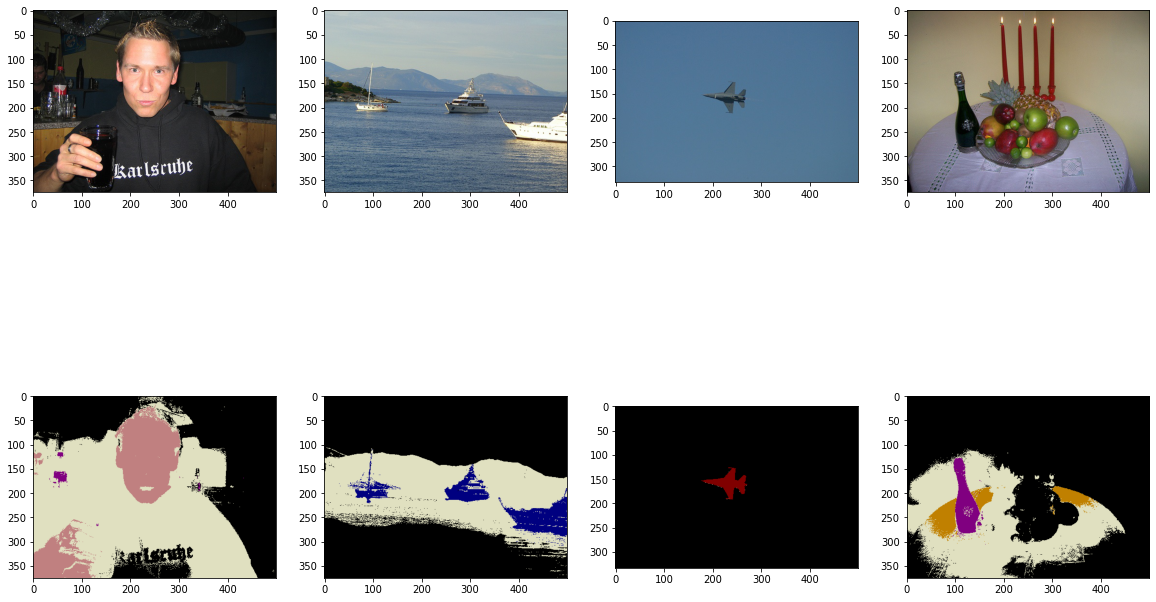

In [9]:
palette = Image.open('../data/SegmentationClass/2007_000032.png').getpalette()

ex_list = []

for i in range(infer_num):
    label = Image.fromarray(conf_list[i].astype(np.uint8))
    label.putpalette(palette)
    label = label.convert('RGB')
    ex_list.append(np.asarray(label))

fig = plt.figure(figsize=(20, 13))

rows = 2
columns = 4

for i in range(4):
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(img_list[i+5])

for i in range(4):
    fig.add_subplot(rows, columns, i+5)
    plt.imshow(ex_list[i+5])

torch.cuda.empty_cache()

# Inferencing localization map of AMN

In [10]:
model = getattr(importlib.import_module(amn_network), 'CAM')()
model.load_state_dict(torch.load(amn_weights_name + '.pth'), strict=True)
model.eval()

In [11]:
with torch.no_grad():

    # oridinary case, we can enumerate data_loader to acquire amn_cam for every query images
    # in this demo, we only infer a single image "2009_002229" due to the time limit
    
    model.cuda()

    img_name = sample_name
    label = sample_label
    size = sample_size
    label_amn = Image.open(os.path.join(ir_label_out_dir, img_name + '.png'))

    strided_size = imutils.get_strided_size(size, 4)

    label_amn_up = np.array(label_amn.resize((size[1], size[0]), resample=Image.NEAREST))

    outputs = [model(img[0].cuda(non_blocking=True), label.unsqueeze(0).expand((img[0].size(0), 20)).cuda())
                for img in sample_img]

    highres_cam = [F.interpolate(torch.unsqueeze(o, 1), size, mode='bilinear', align_corners=False) for o in outputs]
    highres_cam = torch.sum(torch.stack(highres_cam, 0), 0)[:, 0, :size[0], :size[1]] / len(outputs)

    valid_cat = torch.nonzero(label)[:, 0]
    keys = np.pad(valid_cat + 1, (1, 0), mode='constant')

    highres_cam = F.softmax(highres_cam, dim=0)
    highres_cam = highres_cam[keys]
    highres_cam = highres_cam.detach().cpu().numpy()
    highres_cam_norm = (highres_cam - np.min(highres_cam, (1, 2), keepdims=True)) / (np.max(highres_cam, (1, 2), keepdims=True) - np.min(highres_cam, (1, 2), keepdims=True) + 1e-5)
    highres_mask_bg = torch.tensor(label_amn_up == 0).unsqueeze(0).expand(highres_cam.shape).numpy()
    highres_cam[~highres_mask_bg] = highres_cam_norm[~highres_mask_bg]

    sample_amn = highres_cam

/content/AMN/misc/imutils.py:176: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  return ((orig_size[0]-1)//stride+1, (orig_size[1]-1)//stride+1)


# Comparing Original image, CAM and AMN with visualized results

In [12]:
### code from https://github.com/jacobgil/pytorch-grad-cam
def show_cam_on_image(img: np.ndarray,
                      mask: np.ndarray,
                      use_rgb: bool = False,
                      colormap: int = cv2.COLORMAP_JET,
                      image_weight: float = 0.5) -> np.ndarray:
    """ This function overlays the cam mask on the image as an heatmap.
    By default the heatmap is in BGR format.
    :param img: The base image in RGB or BGR format.
    :param mask: The cam mask.
    :param use_rgb: Whether to use an RGB or BGR heatmap, this should be set to True if 'img' is in RGB format.
    :param colormap: The OpenCV colormap to be used.
    :param image_weight: The final result is image_weight * img + (1-image_weight) * mask.
    :returns: The default image with the cam overlay.
    """
    heatmap = cv2.applyColorMap(np.uint8(255 * mask), colormap)
    if use_rgb:
        heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
    heatmap = np.float32(heatmap) / 255

    if np.max(img) > 1:
        raise Exception(
            "The input image should np.float32 in the range [0, 1]")

    if image_weight < 0 or image_weight > 1:
        raise Exception(
            f"image_weight should be in the range [0, 1].\
                Got: {image_weight}")

    cam = (1-image_weight) * heatmap + image_weight * img
    cam = cam / np.max(cam)
    return np.uint8(255 * cam)

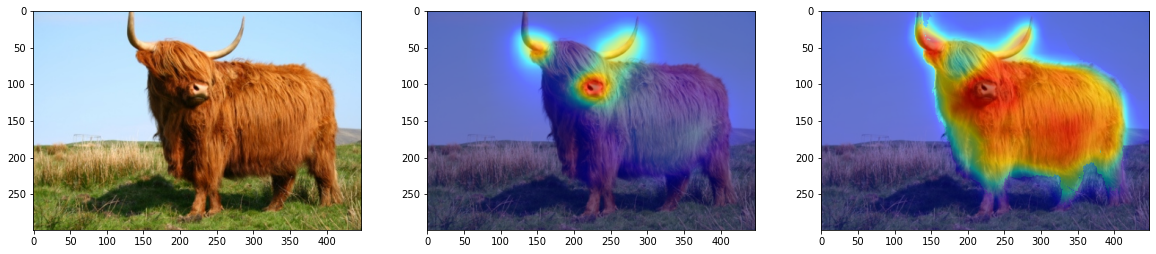

In [13]:
cam_vis = show_cam_on_image((sample_orig/255), sample_cam[0].cpu().numpy(), use_rgb=True)
amn_vis = show_cam_on_image((sample_orig/255), sample_amn[1], use_rgb=True)

fig = plt.figure(figsize=(20, 13))

rows = 1
columns = 3

fig.add_subplot(rows, columns, 1)
plt.imshow(sample_orig)

fig.add_subplot(rows, columns, 2)
plt.imshow(cam_vis)

fig.add_subplot(rows, columns, 3)
plt.imshow(amn_vis)
